In [1]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from gridnext.densenet import DenseNet
from gridnext.gridnet_models import GridNetHexOddr
from gridnext.visium_datasets import create_visium_dataset
from gridnext.training import train_spotwise, train_gridwise
from gridnext.utils import all_fgd_predictions, to_loupe_annots
from gridnext.plotting import performance_curves

In [2]:
# Download data from: https://zenodo.org/uploads/10372917

data_dir = '../data/BA44_testdata'

In [3]:
spaceranger_dirs = sorted(glob.glob(os.path.join(data_dir, 'spaceranger', '*')))
fullres_image_files = sorted(glob.glob(os.path.join(data_dir, 'fullres_images', '*.jpg')))
annot_files = sorted(glob.glob(os.path.join(data_dir, 'annotations', '*.csv')))

save_patches_to = os.path.join(data_dir, 'imgpatches')

# Partition data into training and validation folds:
n_val = 1
train_srd = spaceranger_dirs[n_val:]
train_img = fullres_image_files[n_val:]
train_ann = annot_files[n_val:]

val_srd = spaceranger_dirs[:n_val]
val_img = fullres_image_files[:n_val]
val_ann = annot_files[:n_val]

## 0. Image data pre-processing

In [4]:
# Image transforms to be applied prior to input to DenseNet image classifier (f)
ppx = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
patch_size = (3,224,224)

## 1. Training spot classifier

In [5]:
# Create training and validation datasets
train_pdat = create_visium_dataset(train_srd, annot_files=train_ann, fullres_image_files=train_img,
                                   use_count=False, use_image=True, spatial=False,
                                   img_transforms=ppx, save_patches_to=save_patches_to)
val_pdat = create_visium_dataset(val_srd, annot_files=val_ann, fullres_image_files=val_img,
                                 use_count=False, use_image=True, spatial=False, 
                                 img_transforms=ppx, save_patches_to=save_patches_to)
print('%d training and %d validation spots' % (len(train_pdat), len(val_pdat)))

class_names = train_pdat.classes
print('%d classes' % len(class_names))

19540 training and 2548 validation spots
7 classes


In [6]:
# Create data loaders for training loop
dataloader_spots = {
    'train': DataLoader(train_pdat, batch_size=32, shuffle=True),
    'val': DataLoader(val_pdat, batch_size=32)
}

In [7]:
# Instantiate DenseNet to be used as spot classifier (f)
f = DenseNet(num_classes=len(class_names), small_inputs=False, efficient=False,
             growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0)

In [8]:
# Perform model training and save parameters
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)

output_dir = '../models'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
outfile = os.path.join(output_dir, 'tutorial_f_img.pth')

f, f_val_hist, f_train_hist = train_spotwise(f, dataloader_spots, loss, optimizer, 
                                             num_epochs=10, display=False, outfile=outfile)

Epoch 0/9
----------


KeyboardInterrupt: 

## 2. Training spatial corrector network

In [9]:
# Create training and validation datasets
train_gdat = create_visium_dataset(train_srd, annot_files=train_ann, fullres_image_files=train_img,
                                   use_count=False, use_image=True, spatial=True,
                                   img_transforms=ppx)
val_gdat = create_visium_dataset(val_srd, annot_files=val_ann, fullres_image_files=val_img,
                                 use_count=False, use_image=True, spatial=True, 
                                 img_transforms=ppx)
print('%d training and %d validation arrays' % (len(train_gdat), len(val_gdat)))

class_names = train_gdat.classes
print('%d classes' % len(class_names))

5 training and 1 validation arrays
7 classes


In [10]:
# Create data loaders for training loop
dataloader_grids = {
    'train': DataLoader(train_gdat, batch_size=1, shuffle=True),
    'val': DataLoader(val_gdat, batch_size=1)
}

In [11]:
# Instantiate g network
H_VISIUM = 78
W_VISIUM = 64

g = GridNetHexOddr(f, patch_size, (H_VISIUM, W_VISIUM), n_classes=len(class_names), 
                   use_bn=True, atonce_patch_limit=32)

In [12]:
# Train g network
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(g.corrector.parameters(), lr=1e-3)

# Fixing the parameters of the patch classifier allows slightly faster training, even when only
# optimizing the parameters of the corrector. 
for param in g.patch_classifier.parameters():
    param.requires_grad = False

outfile = os.path.join(output_dir, 'tutorial_g_img')

g, g_val_hist, g_train_hist = train_gridwise(g, dataloader_grids, loss, optimizer, 
                                             num_epochs=10, outfile=outfile)

Epoch 0/9
----------


KeyboardInterrupt: 

## 3. Visualizing performance

### 3.1. Training/validation error over time

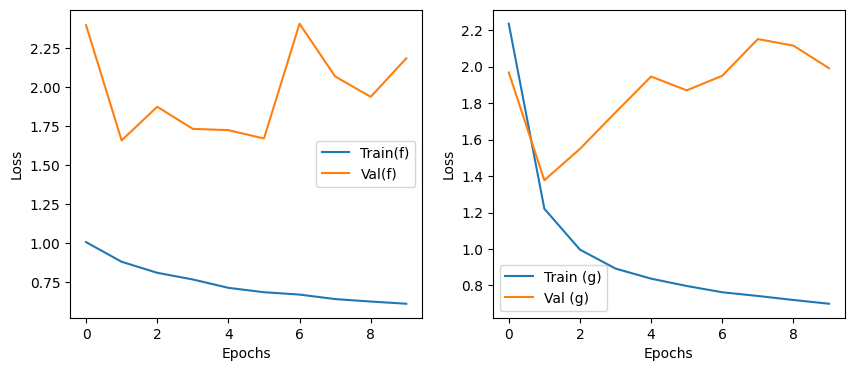

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(f_train_hist, label='Train(f)')
ax[0].plot(f_val_hist, label='Val(f)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(g_train_hist, label='Train (g)')
ax[1].plot(g_val_hist, label='Val (g)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### 3.2. Performance curves

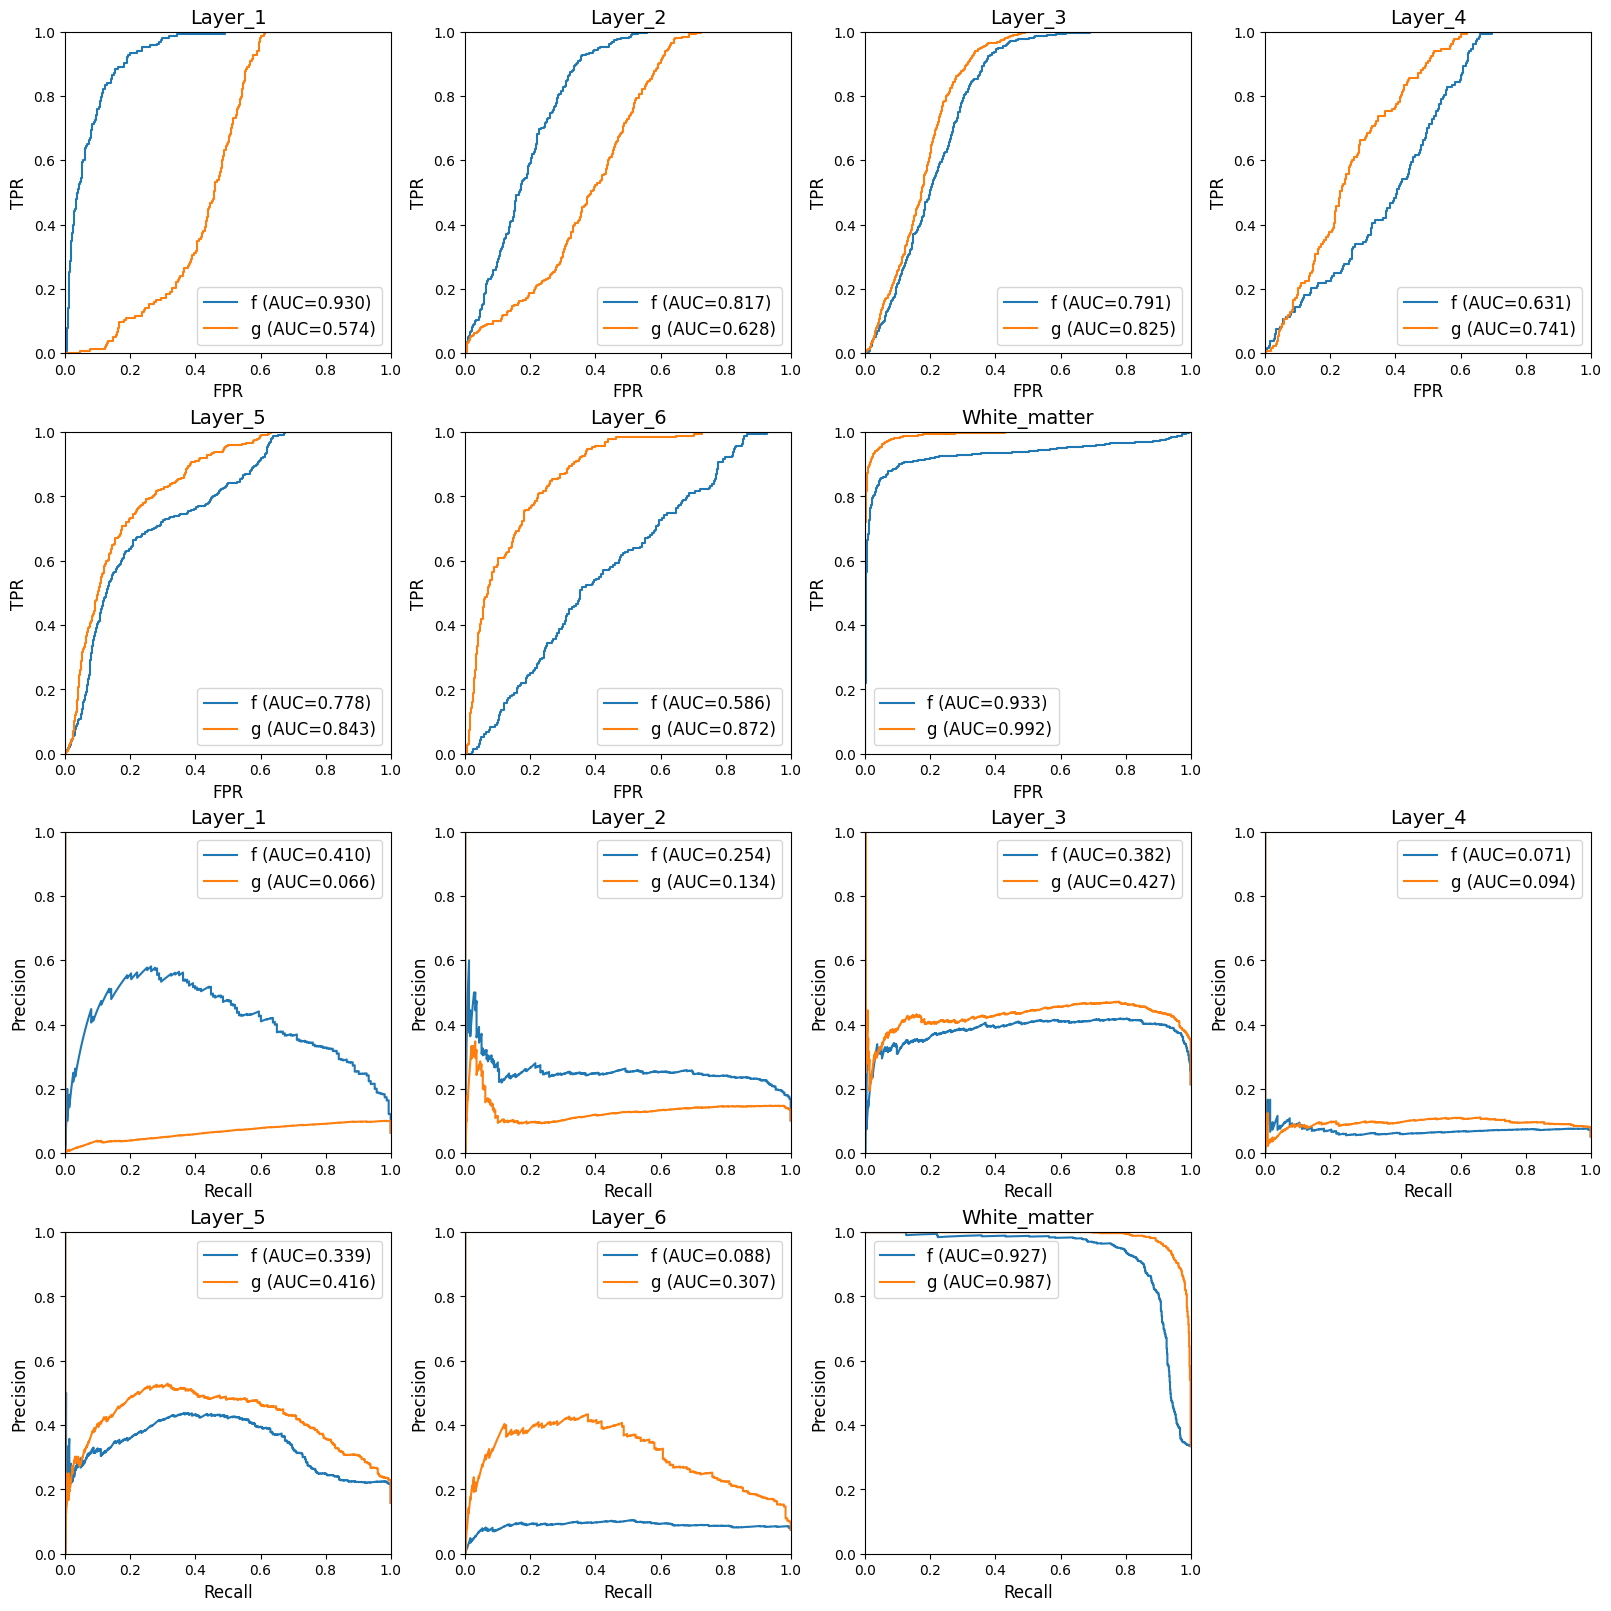

In [14]:
# Performance curves (ROC, precision-recall)
true_vals, f_preds, f_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=True)
true_vals, g_preds, g_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=False)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [f_smax, g_smax], class_names, ['f', 'g'])

### 3.3. Exporting predicted annotations as Loupe file

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.to(device)
g.eval()

annot_dir = '../outputs/annot_preds'
if not os.path.exists(annot_dir):
    os.mkdir(annot_dir)

for i in range(len(val_gdat)):
    x, _ = val_gdat[i]
    x = x.to(device)
    pos_file = val_gdat.position_files[i]
    arr_name = pos_file.split('/')[-4]

    with torch.no_grad():
        y_pred = g(x).squeeze()  # remove (unit) batch dimension
        label_pred = torch.argmax(y_pred, axis=0)
        to_loupe_annots(label_pred, pos_file, os.path.join(annot_dir, arr_name+'_imgpred.csv'), annot_names=class_names)